## GSMaP Gridded data

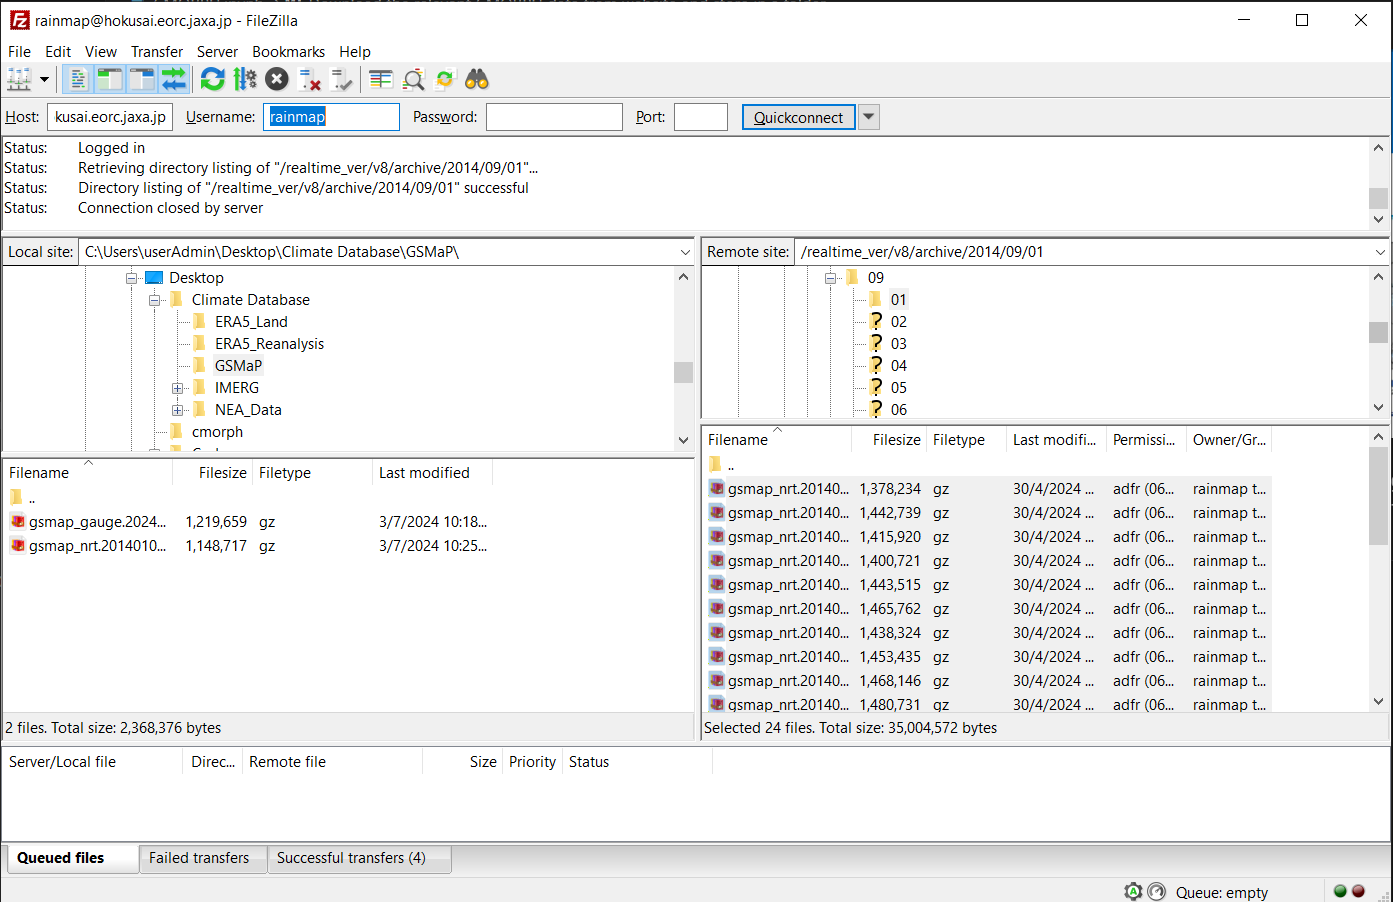

This notebook serves to download gridded GSMaP data via the file transfer protocol (FTP) to the GSMaP host server. The user can input the region of interest, start month/year and end month year. The code logic will:
1) Connect to FTP server
2) Download the relevant files withn the date window
3) Convert to nc file
4) Extract the relevant coordinates and grid boxes of interest
5) Save the files by month

In [ ]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
import os
import dask
import tqdm
import ftplib
import os
import gzip
import xarray as xr
import numpy as np
from tqdm import tqdm
from datetime import datetime
import calendar

def convert_binary_to_nc(binary_file, nc_file, nx=3600, ny=1200, dx=0.1, dy=0.1):
    # Define the coordinates
    lon = np.linspace(0 + dx / 2, 360 - dx / 2, nx)
    lat = np.linspace(60 - dy / 2, -60 + dy / 2, ny)

    # Read the binary data
    data = np.fromfile(binary_file, dtype=np.float32)
    
    # Check if the data size matches the expected size
    if data.size != nx * ny:
        print(f"Error: Data size {data.size} does not match expected size {nx * ny} for file {binary_file}")
        return False

    data = data.reshape(ny, nx)
    
    # Create an xarray Dataset
    ds = xr.Dataset(
        {
            'precipitation': (('lat', 'lon'), data)
        },
        coords={
            'lon': lon,
            'lat': lat
        }
    )
    
    # Set attributes
    ds['precipitation'].attrs['units'] = 'mm/hr'
    ds['precipitation'].attrs['long_name'] = 'GSMaP Precipitation'
    
    # Save to NetCDF
    ds.to_netcdf(nc_file)
    return True

def extract_useful_coordinates(nc_file, subset_nc_file, area_of_interest):
    # Open the NetCDF file
    ds = xr.open_dataset(nc_file)
    
    # Print the latitude and longitude bounds of the dataset
    #print(f"Dataset latitude bounds: {ds['lat'].min().values}, {ds['lat'].max().values}")
    #print(f"Dataset longitude bounds: {ds['lon'].min().values}, {ds['lon'].max().values}")

    # Subset the data based on the area of interest
    subset_ds = ds.sel(
        lon=slice(area_of_interest['lon_min'], area_of_interest['lon_max']),
        lat=slice(area_of_interest['lat_max'], area_of_interest['lat_min'])
    )

    # Check if the subsetted data is empty
    if subset_ds['precipitation'].size == 0 or subset_ds['precipitation'].isnull().all():
        print("No numeric data to plot.")
        return False
    
    # Save the subsetted data to a new NetCDF file
    subset_ds.to_netcdf(subset_nc_file)
    return True

def download_and_process_file(ftp, file, local_dir, extracted_dir, area_of_interest, year, month):
    local_filepath = os.path.join(local_dir, file)
    subset_nc_file_path = os.path.join(extracted_dir, str(year), month, file.replace('.gz', '.nc'))

    try:
        with open(local_filepath, 'wb') as local_file:
            ftp.retrbinary(f'RETR {file}', local_file.write)


        # Unzip the file
        with gzip.open(local_filepath, 'rb') as f_in:
            with open(local_filepath.replace('.gz', ''), 'wb') as f_out:
                f_out.write(f_in.read())

        # Convert binary to NetCDF
        if not convert_binary_to_nc(local_filepath.replace('.gz', ''), local_filepath.replace('.gz', '.nc')):
            return
        
        # Ensure year/month subdirectories exist
        os.makedirs(os.path.dirname(subset_nc_file_path), exist_ok=True)
        
        # Extract useful coordinates
        extract_useful_coordinates(local_filepath.replace('.gz', '.nc'), subset_nc_file_path, area_of_interest)
        
        # Clean up
        os.remove(local_filepath)
        os.remove(local_filepath.replace('.gz', ''))
        os.remove(local_filepath.replace('.gz', '.nc'))
    except Exception as e:
        print(f"Error processing {file}: {e}")
def download_gz_files(ftp_host, ftp_user, ftp_password, remote_dir, local_dir, extracted_dir, start_year, end_year, area_of_interest):
    try:
        # Connect to FTP server
        ftp = ftplib.FTP(ftp_host)
        ftp.login(user=ftp_user, passwd=ftp_password)

        # Ensure local and extracted directories exist
        os.makedirs(local_dir, exist_ok=True)
        os.makedirs(extracted_dir, exist_ok=True)

        # Iterate through the years in the specified range
        for year in range(start_year, end_year + 1):
            start_m = start_month if year == start_year else 1
            end_m = end_month if year == end_year else 12
            year_dir = f"{remote_dir}/{year}"
            try:
                ftp.cwd(year_dir)
                print(f"Entering directory: {year_dir}")
            except ftplib.error_perm:
                print(f"Skipping {year_dir}, not a directory.")
                continue

            # List all month directories
            months = ftp.nlst()
            months.sort()
            for month in months:
                if int(month) < start_m or int(month) > end_m:
                    continue
                month_dir = f"{year_dir}/{month}"

                try:
                    ftp.cwd(month_dir)
                    print(f"Entering directory: {month_dir}")
                except ftplib.error_perm:
                    print(f"Skipping {month_dir}, not a directory.")
                    continue

                # List all day directories
                days = ftp.nlst()
                days.sort()
                for day in days:
                    day_dir = f"{month_dir}/{day}"
                    try:
                        ftp.cwd(day_dir)
                        print(f"Entering directory: {day_dir}")
                    except ftplib.error_perm:
                        print(f"Skipping {day_dir}, not a directory.")
                        continue

                    # List all .gz files
                    files = ftp.nlst()
                    gz_files = [file for file in files if file.endswith('.gz')]

                    # Ensure local day directory exists
                    local_day_dir = os.path.join(local_dir, str(year), month, day)
                    if not os.path.exists(local_day_dir):
                        os.makedirs(local_day_dir)

                    # Download and process each .gz file
                    for file in gz_files:
                        print(f"Processing file: {file}")
                        download_and_process_file(ftp, file, local_day_dir, extracted_dir, area_of_interest, year, month)

                    # Move back to the month directory
                    ftp.cwd('..')

                # Move back to the year directory
                ftp.cwd('..')

            # Move back to the root directory
            ftp.cwd('..')

        # Close the FTP connection
        ftp.quit()
    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    ftp_host = 'hokusai.eorc.jaxa.jp'
    ftp_user = 'rainmap'
    ftp_password = 'Niskur+1404'
    remote_dir = '/realtime_ver/v8/archive'
    local_dir = r'c:\Users\Jun Wei\Desktop\GSMaP_files\temp'
    extracted_dir = r'c:\Users\Jun Wei\Desktop\GSMaP_files\extracted'
    
    start_year = 2023  # <---- Change dates here
    start_month = 12
    end_year = 2023 
    end_month = 12
    # CHANGE AREA HERE
    area_of_interest = {'lat_min': -7.29, 'lon_min': 93.16, 'lat_max': 9.972, 'lon_max': 110.422}
    
    # Download and process files
    download_gz_files(ftp_host, ftp_user, ftp_password, remote_dir, local_dir, extracted_dir, start_year, end_year, area_of_interest)

    print("Download, extraction, and conversion processes completed.")

## Merging and compress

Pretty much what it says, merge by month then compress

In [ ]:
import os
import xarray as xr
import netCDF4 as nc
from dask.diagnostics import ProgressBar
import pandas as pd
folder_path = r"c:\Users\Jun Wei\Desktop\GSMaP_files\extracted"
def merge(month):
    month_path = os.path.join(folder_path, year, month)
    nc_files = [os.path.join(month_path, f) for f in os.listdir(month_path) if f.endswith('.nc')]
    nc_files.sort()
    
    datasets = []
    for file in nc_files:
        # Extract datetime from filename
        filename = os.path.basename(file)
        date_str = filename.split('.')[1]
        time_str = filename.split('.')[2]
        dt = pd.to_datetime(f"{date_str} {time_str}", format='%Y%m%d %H%M')
        
        # Open dataset and assign time dimension
        ds = xr.open_dataset(file)
        ds = ds.expand_dims({'time': [dt]})
        datasets.append(ds)
    
    try:
        combined = xr.concat(datasets, dim='time')
        output_path = os.path.join(folder_path, year,month, f"{int(str(year+month))}_combined.nc")
        
        encoding = {var: {"zlib": True, "complevel": 9} for var in combined.data_vars}
        
        with ProgressBar():
            combined.to_netcdf(output_path, encoding=encoding)
        
        compress_netcdf(output_path)
        print(f"{month} combined and compressed successfully")
    except Exception as e:
        print(f"{month} failed: {e}")

def compress_netcdf(file):
    src_dataset = nc.Dataset(file, 'r')
    compressed_file = file.replace(".nc", "_compressed.nc")
    dst_dataset = nc.Dataset(compressed_file, 'w', format='NETCDF4')
    
    for attr in src_dataset.ncattrs():
        dst_dataset.setncattr(attr, src_dataset.getncattr(attr))
    for dim_name, dim in src_dataset.dimensions.items():
        dst_dataset.createDimension(dim_name, len(dim) if not dim.isunlimited() else None)
    for var_name, var in src_dataset.variables.items():
        dst_var = dst_dataset.createVariable(var_name, var.datatype, var.dimensions, zlib=True, complevel=9, shuffle=True)
        dst_var.setncatts({k: var.getncattr(k) for k in var.ncattrs()})
        dst_var[:] = var[:]
    
    dst_dataset.close()
    src_dataset.close()
    print(f"{file} compressed")

folder_path = r"c:\Users\Jun Wei\Desktop\GSMaP_files\extracted"
os.listdir(folder_path)
for year in os.listdir(folder_path):
    #if year == "2023":
    for month in os.listdir(os.path.join(folder_path, year)):
        merge(month)
        print(f"{year} {month} done")